In [1]:
import numpy as np
import scipy
import math
from scipy import ndimage
%matplotlib inline
from matplotlib import pyplot as plt
ds = np.load('modelnet10_train.npz')
ys = np.load('modelnet10_val.npz')
samples = ds['samples']
labels = ds['labels']
val_samples = ys['samples']
val_labels = ys['labels']
print("samples shape: %s, labels shape: %s" %(samples.shape, labels.shape)) 
print("val_samples shape: %s, val_labels shape: %s" %(val_samples.shape, val_labels.shape))


samples shape: (3991, 4000, 3), labels shape: (3991,)
val_samples shape: (908, 4000, 3), val_labels shape: (908,)


In [2]:
def point_cloud_to_volume(points, size=32):
    vol = np.zeros((size,size,size))
    locations = np.copy(points)
    locations[:] *= (size-1)
    locations = locations.astype(int)
    locations[locations >= size] = 0.0
    locations[locations < 0] = 0.0
    vol[locations[:,0],locations[:,1],locations[:,2]] = 1.0
    return vol

def vol2depthmap(volume_array, bg_val=32):
    vol = volume_array.argmax(2)
    vol[vol == 0] = bg_val
    return vol

In [3]:
v = point_cloud_to_volume(samples[36])

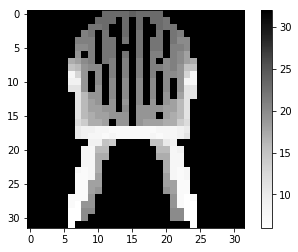

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.imshow(vol2depthmap(v), interpolation='nearest', cmap='Greys')
plt.colorbar()

In [5]:
import time
#angle = 60
rot_60=np.asarray([[1,0,0],
                        [0,0.5000000, -0.8660254],
                        [0,0.8660254,  0.5000000]])

#angle = 30
rot_30=np.asarray([[1.0000000,  0.0000000,  0.0000000],
                     [0.0000000,  0.8660254, -0.5000000],
                     [0.0000000,  0.5000000,  0.8660254]])

def timing(f):
    def wrap(*args):
        time1 = time.time()
        ret = f(*args)
        time2 = time.time()
        print (' function took %0.3f ms' % ((time2-time1)*1000.0))
        return ret
    return wrap

def rotate_cloud(x):
    y = np.subtract(x,0.5) 
    y = rot_30.dot(y.T).T
    y = np.add(y,0.5) 
    return y

@timing
def convert_data(samples, length):
    super_arr = []
    #for index_arr in range (0, length):
        
        
    for index in range (0, length):
        super_arr.append(np.zeros((12,32,32)))
        temp_cloud = samples[index]
        super_arr[index][0] = vol2depthmap(point_cloud_to_volume(temp_cloud))
        for angle_index in range (1,12):
            temp_cloud = rotate_cloud(temp_cloud)
            super_arr[index][angle_index] = vol2depthmap(point_cloud_to_volume(temp_cloud))
    return super_arr    

In [6]:
samples2 = convert_data(val_samples,908)
print ("done")

 function took 3412.639 ms
done


In [7]:
shapes_number = 3991 #how much shapes do you want to process , max is len(samples)
samples1 = convert_data(samples,shapes_number)
print ("done")

 function took 13424.327 ms
done


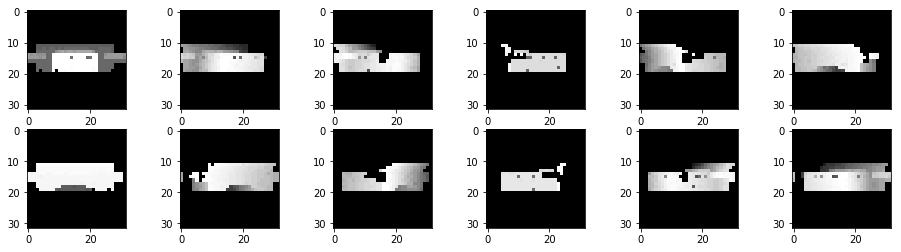

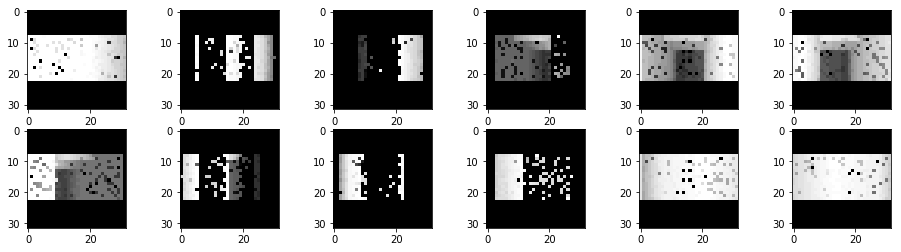

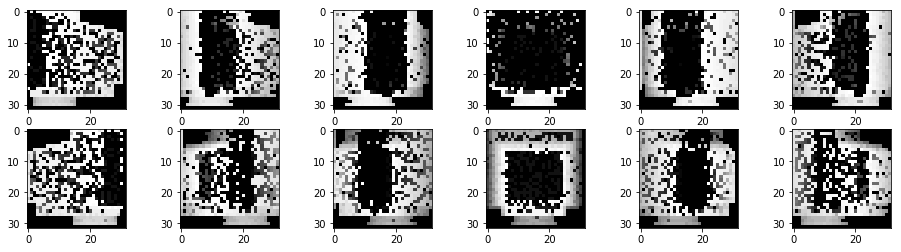

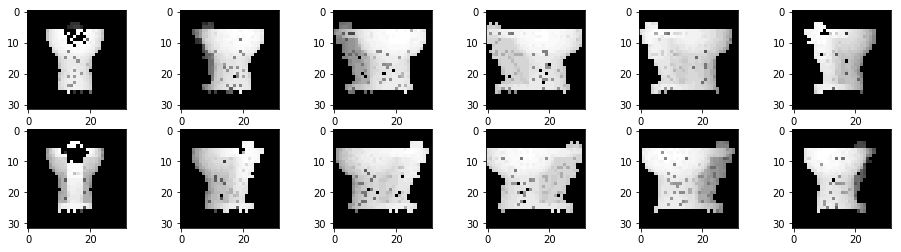

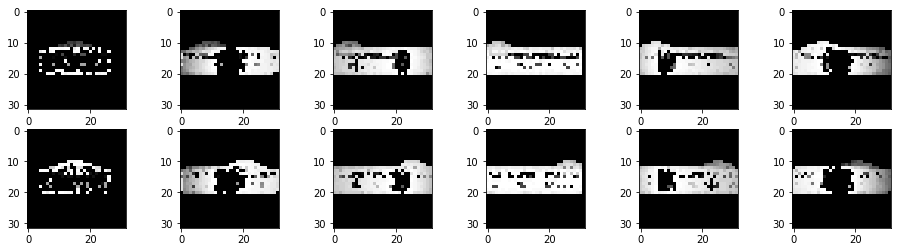

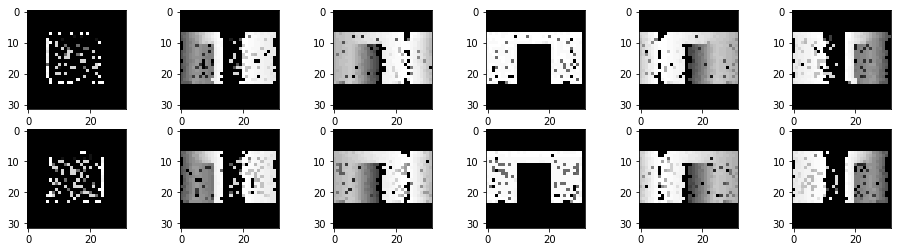

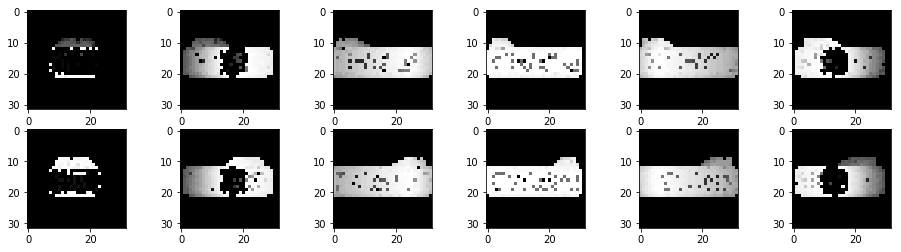

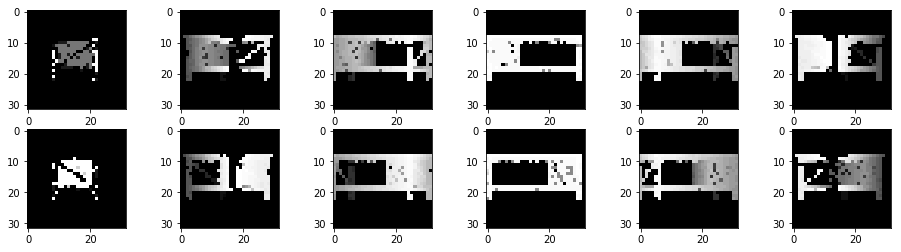

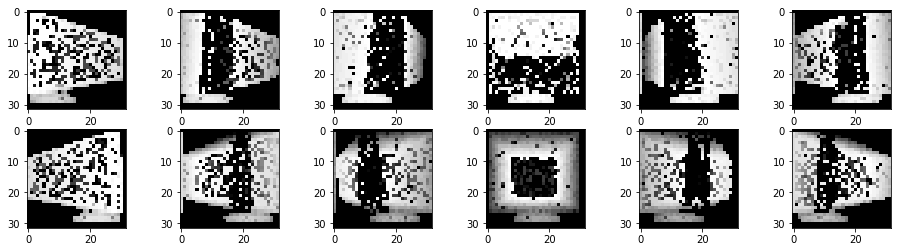

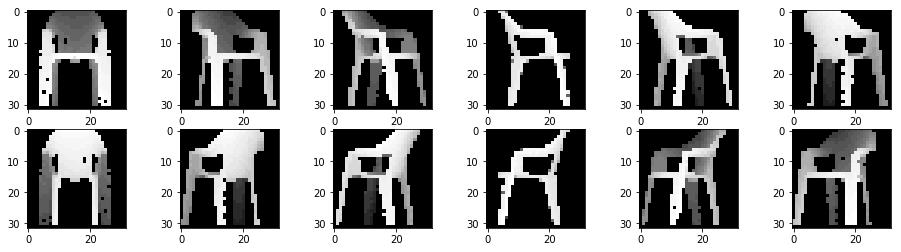

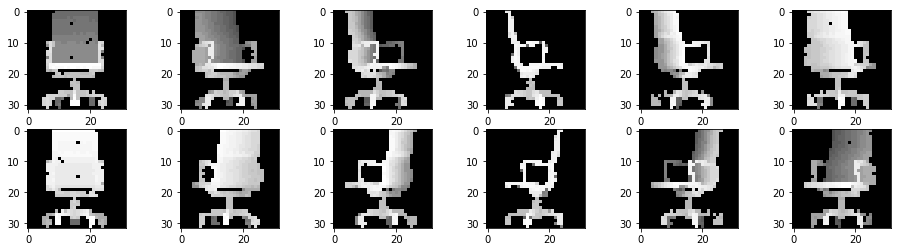

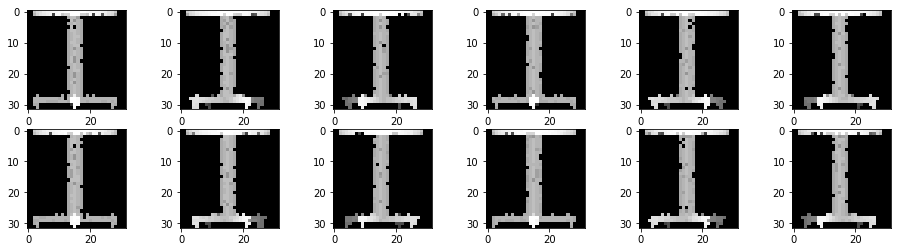

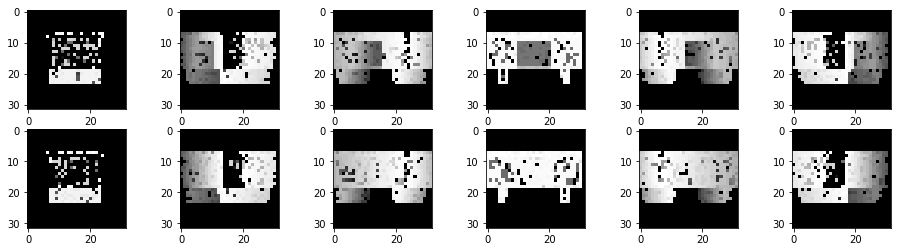

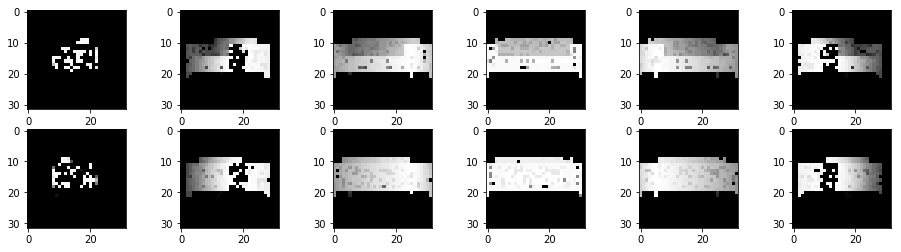

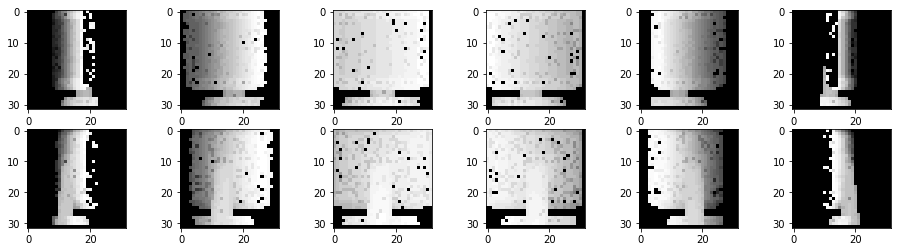

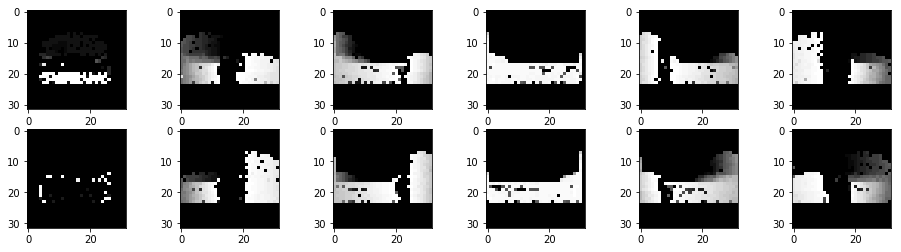

KeyboardInterrupt: 

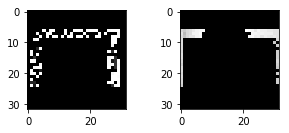

In [13]:
%matplotlib inline
from matplotlib import pyplot as plt
#plt.imshow(samples1[0][0],interpolation='nearest',cmap='jet')
#plt.colorbar()

for p in range(0, shapes_number):
    fig=plt.figure(figsize=(16, 4))
    for i in range(0, 12):
        img = samples1[p][i]
        fig.add_subplot(2, 6, i+1)
        plt.imshow(img,interpolation='nearest',cmap='Greys')
    plt.show()

In [ ]:
from __future__ import print_function
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

batch_size = 128
num_classes = 10
epochs = 15

# input image dimensions
img_rows, img_cols = 32, 32

# the data, split between train and test sets
my_train = [] # empty list
for i in range(0, 3991):
    x = vol2depthmap(point_cloud_to_volume(samples[i]))
    my_train.append(x)
    
my_train = np.asarray(my_train)
        
my_test = [] # empty list
for i in range(0, 908):
    x = vol2depthmap(point_cloud_to_volume(val_samples[i]))
    my_test.append(x)
    
my_test = np.asarray(my_test)

x_train = my_train
y_train = labels
x_test = my_test
y_test = val_labels

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)

else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [18]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
class SplitLayer(keras.layers.Layer):
    """
    Layer expects a tensor (multi-dimensonal array) of shape (samples, views, ...)
    and returns a list of #views elements, each of shape (samples, ...)
    """
    
    def __init__(self, num_splits, **kwargs):
        self.num_splits = num_splits
        super(SplitLayer, self).__init__(**kwargs)
    
    def call(self, x):
        return [x[:, i] for i in range(self.num_splits)]

    def compute_output_shape(self, input_shape):
        return [(input_shape[0],) + input_shape[2:]]*self.num_splits

def get_test_shared_model():    
    num_channels = 5 # for example
    cnn = keras.models.Sequential()
    cnn.add(keras.layers.Conv2D(num_channels, kernel_size=(3, 3),
                    activation='relu',
                    input_shape=(32,32,1)))
    cnn.add(keras.layers.BatchNormalization())
    cnn.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
    cnn.add(keras.layers.Conv2D(num_channels*2, (3, 3), activation='relu'))
    #cnn.add(keras.layers.BatchNormalization())
    #cnn.add(keras.layers.Activation('tanh'))
    cnn.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
    cnn.add(keras.layers.Flatten())
    cnn.add(keras.layers.Dense(64, activation='relu'))
    return cnn

def test_split_layer():
    num_views = 12 # or any other number ...
    cnn = get_test_shared_model()
    input = keras.layers.Input((num_views, 32, 32, 1))
    views = SplitLayer(num_views)(input) # list of keras-tensors
    processed_views = [] # empty list
    for view in views:
        x = cnn(view)
        processed_views.append(x)
    
    pooled_views = keras.layers.Maximum()(processed_views)
    x = Dropout(0.25)(pooled_views) 
    x = keras.layers.Dense(128)(x)
    x = Dropout(0.5)(x) 
    x = Dense(num_classes, activation='softmax')(x)
    model = keras.models.Model(input, x)
    
    return model
    

In [19]:
batch_size = 20
num_classes = 10
epochs = 30
num_views= 12
# input image dimensions
img_rows, img_cols = 32, 32

samples1 = np.asarray(samples1)
samples2 = np.asarray(samples2)

x_train = samples1
y_train = labels
x_test = samples2
y_test = val_labels

x_train = x_train.reshape(x_train.shape[0], num_views, img_rows, img_cols,1)
x_test = x_test.reshape(x_test.shape[0], num_views, img_rows, img_cols,1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255
x_test /= 255

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (3991, 12, 32, 32, 1)
3991 train samples
908 test samples


In [20]:
model = test_split_layer()

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

predictions = model.predict(x_test,batch_size=batch_size, verbose=0)
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
model.save_weights('file2.h5')

Train on 3991 samples, validate on 908 samples
Epoch 1/30
3991/3991 [==============================] - 33s - loss: 1.1826 - acc: 0.6151 - val_loss: 0.7764 - val_acc: 0.7192
Epoch 2/30
3991/3991 [==============================] - 34s - loss: 0.6217 - acc: 0.7995 - val_loss: 0.6334 - val_acc: 0.7819
Epoch 3/30
3991/3991 [==============================] - 35s - loss: 0.4983 - acc: 0.8399 - val_loss: 0.5486 - val_acc: 0.8282
Epoch 4/30
3991/3991 [==============================] - 34s - loss: 0.4344 - acc: 0.8559 - val_loss: 0.4927 - val_acc: 0.8326
Epoch 5/30
3991/3991 [==============================] - 34s - loss: 0.3716 - acc: 0.8780 - val_loss: 0.5353 - val_acc: 0.8260
Epoch 6/30
3991/3991 [==============================] - 34s - loss: 0.3247 - acc: 0.8950 - val_loss: 0.5146 - val_acc: 0.8381
Epoch 7/30
3991/3991 [==============================] - 34s - loss: 0.2939 - acc: 0.9033 - val_loss: 0.5023 - val_acc: 0.8414
Epoch 8/30
3991/3991 [==============================] - 34s - loss: 0.2

In [28]:

y_classes = predictions.argmax(axis=-1)
from sklearn.metrics import confusion_matrix
import itertools
from matplotlib import pyplot as plt

cm = confusion_matrix(val_labels, y_classes)
print(cm)

[[36  7  0  2  0  0  0  5  0  0]
 [ 0 96  0  0  0  0  0  1  3  0]
 [ 0  0 97  0  0  0  0  2  1  0]
 [ 0  0  3 68  0  5  2  5  2  1]
 [ 0  0  0  3 68  1 14  0  0  0]
 [ 0  0  0  1  3 96  0  0  0  0]
 [ 0  0  2  0 21  1 56  0  6  0]
 [ 0  0  1  1  1  0  1 96  0  0]
 [ 0  0  0 46  0  0  0  0 54  0]
 [ 0  0  1  0  0  0  1  0  0 98]]


                    bathtub         bed       chair        desk     dresser     monitor night_stand        sofa       table      toilet 
        bathtub        36.0         7.0         0.0         2.0         0.0         0.0         0.0         5.0         0.0         0.0 
            bed         0.0        96.0         0.0         0.0         0.0         0.0         0.0         1.0         3.0         0.0 
          chair         0.0         0.0        97.0         0.0         0.0         0.0         0.0         2.0         1.0         0.0 
           desk         0.0         0.0         3.0        68.0         0.0         5.0         2.0         5.0         2.0         1.0 
        dresser         0.0         0.0         0.0         3.0        68.0         1.0        14.0         0.0         0.0         0.0 
        monitor         0.0         0.0         0.0         1.0         3.0        96.0         0.0         0.0         0.0         0.0 
    night_stand         0.0         0.0  

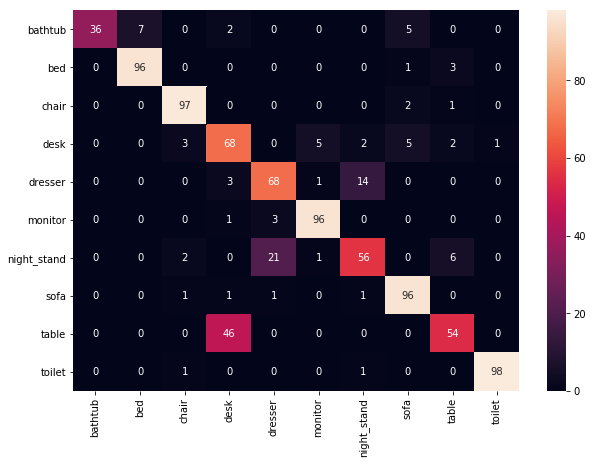

In [29]:
from sklearn.metrics import confusion_matrix

def print_cm(cm, labels, hide_zeroes=False, hide_diagonal=False, hide_threshold=None):
    """pretty print for confusion matrixes"""
    columnwidth = max([len(x) for x in labels] + [5])  # 5 is value length
    empty_cell = " " * columnwidth
    # Print header
    print("    " + empty_cell, end=" ")
    for label in labels:
        print("%{0}s".format(columnwidth) % label, end=" ")
    print()
    # Print rows
    for i, label1 in enumerate(labels):
        print("    %{0}s".format(columnwidth) % label1, end=" ")
        for j in range(len(labels)):
            cell = "%{0}.1f".format(columnwidth) % cm[i, j]
            if hide_zeroes:
                cell = cell if float(cm[i, j]) != 0 else empty_cell
            if hide_diagonal:
                cell = cell if i != j else empty_cell
            if hide_threshold:
                cell = cell if cm[i, j] > hide_threshold else empty_cell
            print(cell, end=" ")
        print()

# first generate with specified labels
labels1= ['bathtub', 'bed', 'chair', 'desk', 'dresser','monitor', 'night_stand', 'sofa', 'table', 'toilet']
cm = confusion_matrix(val_labels, y_classes)

# then print it in a pretty way
print_cm(cm, labels1)

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array = cm
df_cm = pd.DataFrame(array, index = [i for i in labels1],
                  columns = [i for i in labels1])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)



In [27]:

## bonus : keras layer getting n views and returning 2n views (with mirrors)

from keras import backend as K
from keras.engine.topology import Layer

class MirrorLayer(Layer):
    def __init__(self, num_splits, **kwargs):
        self.num_splits = num_splits
        super(SplitLayer, self).__init__(**kwargs)
    
    def call(self, x):
        return [np.dstack((x[:, i], np.fliplr(x[:, i]))) for i in range(self.num_splits)]

    def compute_output_shape(self, input_shape):
        return [(input_shape[0],) + input_shape[2:]]*self.num_splits
    
    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.kernel = self.add_weight(name='kernel', 
                                      shape=(input_shape[1], self.output_dim),
                                      initializer='uniform',
                                      trainable=True)
        super(MirrorLayer, self).build(input_shape)  # Be sure to call this somewhere!
